# This notebook is meant for re-creating the plots shown in the paper

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchmetrics.functional import accuracy, auroc, average_precision

import pandas as pd
import seaborn as sns

sys.path.insert(0, os.path.abspath("../"))
from src.eval.visualizations_base import (
    create_runs_from_folder, 
    create_ensemble_from_folder, 
    generate_slide_vis_from_run,
)
from src.eval.plot_functions import (
    compute_metrics,
    compute_id_ood_reject_metrics,
    visualize_tiles_by_uncertainty,
    plot_slide_images,
    compute_metrics_label_noise,
    compare_ece, 
)
from src.eval.dataset_statistics import show_slide_statistics

%load_ext autoreload
%autoreload 2

/home/kti03/miniconda3/envs/uctbm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We start by loading the test results to generate the plots for tile classifier performance from Fig.1:

Make sure to set `RUN_DIR` to the directory where the predicitions from the different runs are stored.

In [25]:
_environ = dict(os.environ) 
os.environ["DATASET_LOCATION"] = "PLACEHOLDER1"
RUN_DIR = Path("PLACEHOLDER2")
CONFIG_PATH = "logs/config.yaml"
SAVE_PATH = Path.cwd().parent / "figures"

# Helper functions for printing LateX tables
def iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    return q75 - q25

def _latex_meanvar_formatter(x):
    mean, var = x
    return f"$ {mean:.3f}_{{\\pm{var:.3f}}}$"

def _map_to_mean_auc(entry):
    values = torch.tensor(list(entry.values()))
    
    std, mean = torch.std_mean(values)
    return mean.item(),std.item()

def print_latex_table(df, groupby=["split", "method"]):
    grouped_results = df.groupby(by=groupby)

    median_iqr = grouped_results.agg(lambda x: (np.median(x), iqr(x)))

    print(median_iqr.to_latex(formatters=[_latex_meanvar_formatter] * len(median_iqr.columns), escape=False))

In [18]:
runs = [
    *create_runs_from_folder("strong/resnet", run_dir=RUN_DIR, config_path=CONFIG_PATH, name="ResNet", max_num=5),
    # *create_runs_from_folder("strong/ts", run_dir=RUN_DIR, config_path=CONFIG_PATH, name="Temp Scaling"),
    *create_ensemble_from_folder(
        "strong/resnet_ensemble", members_per_ensemble=5, run_dir=RUN_DIR, config_path=CONFIG_PATH, name="ResNet Ensemble"
    ),
    *create_runs_from_folder("strong/mcdo", run_dir=RUN_DIR, config_path=CONFIG_PATH, name="MCDO", max_num=5),
    *create_ensemble_from_folder(
        "strong/mcdo_ensemble", members_per_ensemble=5, run_dir=RUN_DIR, config_path=CONFIG_PATH, name="MCDO Ensemble"
    ),
    *create_runs_from_folder("strong/tta", run_dir=RUN_DIR, config_path=CONFIG_PATH, name="TTA", max_num=5),
    *create_ensemble_from_folder(
        "strong/tta_ensemble", members_per_ensemble=5, run_dir=RUN_DIR, config_path=CONFIG_PATH, name="TTA Ensemble"
    ),
    *create_runs_from_folder("strong/svi", run_dir=RUN_DIR, config_path=CONFIG_PATH, name="SVI", max_num=5),
    *create_ensemble_from_folder(
        "strong/svi", members_per_ensemble=5, run_dir=RUN_DIR, config_path=CONFIG_PATH, name="SVI Ensemble"
    ),
]
print("Total number of runs: ", len(runs))

Total number of runs:  40


Disclaimer: The runtime of the following two cells takes some time each.

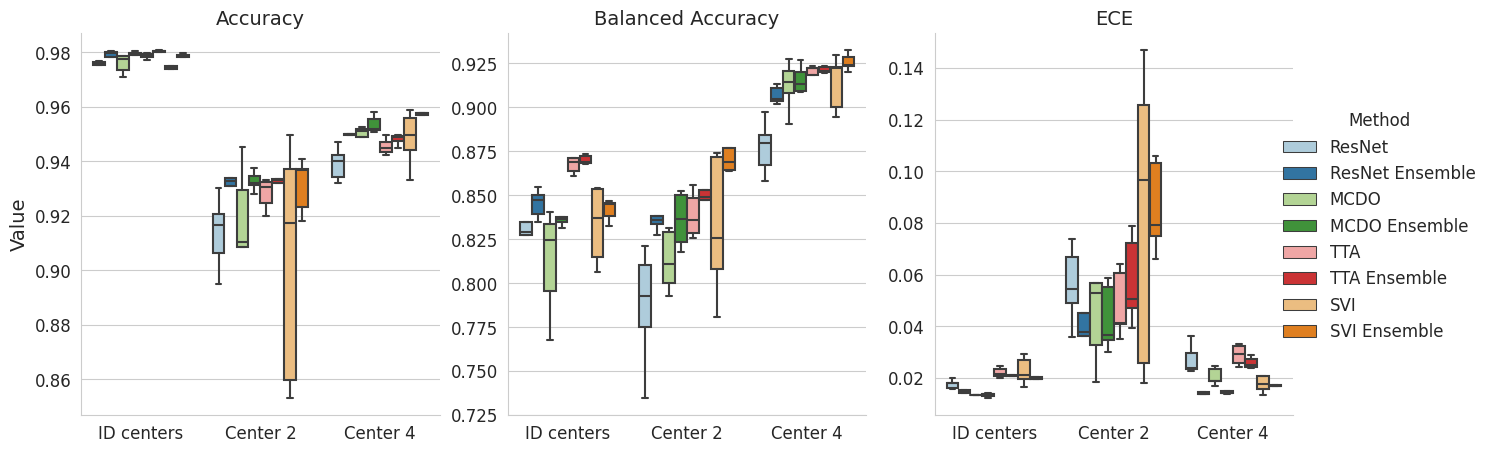

In [4]:
df_tc = compute_metrics(
    runs, 
    split=["test_id", "test_ood2", "test_ood4"], 
    metrics=["Accuracy", "Balanced Accuracy", "ECE"],
    rc_args={"xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12, "legend.title_fontsize": 12},
    color_palette="Paired",
    # fname = SAVE_PATH / "metric_boxplot.pdf",
    )

In [5]:
# Print plot results as LaTeX table
print_latex_table(df_tc)

\begin{tabular}{lllll}
\toprule
           &              &             Accuracy &    Balanced Accuracy &                  ECE \\
split & method &                      &                      &                      \\
\midrule
Center 2 & MCDO &  $ 0.910_{\pm0.021}$ &  $ 0.811_{\pm0.029}$ &  $ 0.053_{\pm0.024}$ \\
           & MCDO Ensemble &  $ 0.932_{\pm0.003}$ &  $ 0.837_{\pm0.027}$ &  $ 0.037_{\pm0.020}$ \\
           & ResNet &  $ 0.917_{\pm0.015}$ &  $ 0.793_{\pm0.036}$ &  $ 0.055_{\pm0.018}$ \\
           & ResNet Ensemble &  $ 0.933_{\pm0.003}$ &  $ 0.836_{\pm0.005}$ &  $ 0.038_{\pm0.009}$ \\
           & SVI &  $ 0.917_{\pm0.077}$ &  $ 0.825_{\pm0.064}$ &  $ 0.097_{\pm0.100}$ \\
           & SVI Ensemble &  $ 0.937_{\pm0.014}$ &  $ 0.869_{\pm0.012}$ &  $ 0.079_{\pm0.028}$ \\
           & TTA &  $ 0.931_{\pm0.008}$ &  $ 0.836_{\pm0.020}$ &  $ 0.041_{\pm0.020}$ \\
           & TTA Ensemble &  $ 0.933_{\pm0.002}$ &  $ 0.849_{\pm0.006}$ &  $ 0.050_{\pm0.025}$ \\
Center 4 & MCDO &  $

Next, we plot the Accuracy-Reject Curves from Fig.2:

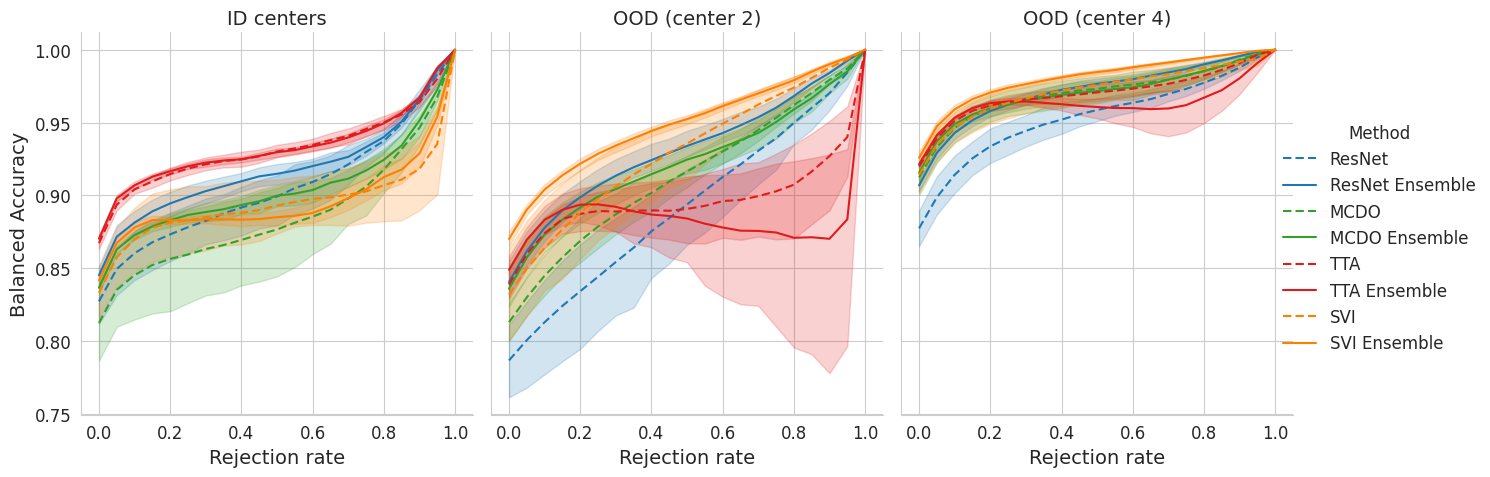

In [6]:
auc = compute_id_ood_reject_metrics(
    runs,
    metric_func=lambda preds, label: accuracy(preds, label, average="macro", num_classes=2),
    uc_thresh="confidence",
    order="asc",
    num_steps=20,
    x_range=[0.0, 1.0],
    rc_args = {"xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12, "legend.title_fontsize": 12},
    color_palette="colorblind",
    # fname = SAVE_PATH / "acc_reject_curves.pdf",
)

In [7]:
# Print LaTeX AUC Table
auc_df = pd.DataFrame(auc)
mapped_df = auc_df.applymap(_map_to_mean_auc)

print(mapped_df.to_latex(formatters=[_latex_meanvar_formatter] * len(mapped_df.columns), escape=False))

\begin{tabular}{llll}
\toprule
{} &              test_id &            test_ood2 &            test_ood4 \\
\midrule
ResNet          &  $ 0.906_{\pm0.017}$ &  $ 0.893_{\pm0.031}$ &  $ 0.954_{\pm0.010}$ \\
ResNet Ensemble &  $ 0.918_{\pm0.007}$ &  $ 0.932_{\pm0.010}$ &  $ 0.972_{\pm0.004}$ \\
MCDO            &  $ 0.886_{\pm0.030}$ &  $ 0.914_{\pm0.012}$ &  $ 0.971_{\pm0.010}$ \\
MCDO Ensemble   &  $ 0.905_{\pm0.008}$ &  $ 0.924_{\pm0.012}$ &  $ 0.971_{\pm0.007}$ \\
TTA             &  $ 0.932_{\pm0.005}$ &  $ 0.897_{\pm0.025}$ &  $ 0.970_{\pm0.004}$ \\
TTA Ensemble    &  $ 0.933_{\pm0.002}$ &  $ 0.884_{\pm0.044}$ &  $ 0.963_{\pm0.009}$ \\
SVI             &  $ 0.895_{\pm0.027}$ &  $ 0.931_{\pm0.025}$ &  $ 0.972_{\pm0.012}$ \\
SVI Ensemble    &  $ 0.896_{\pm0.006}$ &  $ 0.949_{\pm0.003}$ &  $ 0.981_{\pm0.002}$ \\
\bottomrule
\end{tabular}



For showing the most certain and most uncertain tiles (Fig. 3), we choose the uncertainties generated from the first ResNet Ensemble:

In [8]:
runs = [
    *create_ensemble_from_folder(
        "strong/resnet_ensemble", members_per_ensemble=5, run_dir=RUN_DIR, config_path=CONFIG_PATH, name="ResNet Ensemble"
    ),
]
run = runs[0]

Generating Camelyon17 test dataset
Generating Camelyon17 OOD dataset


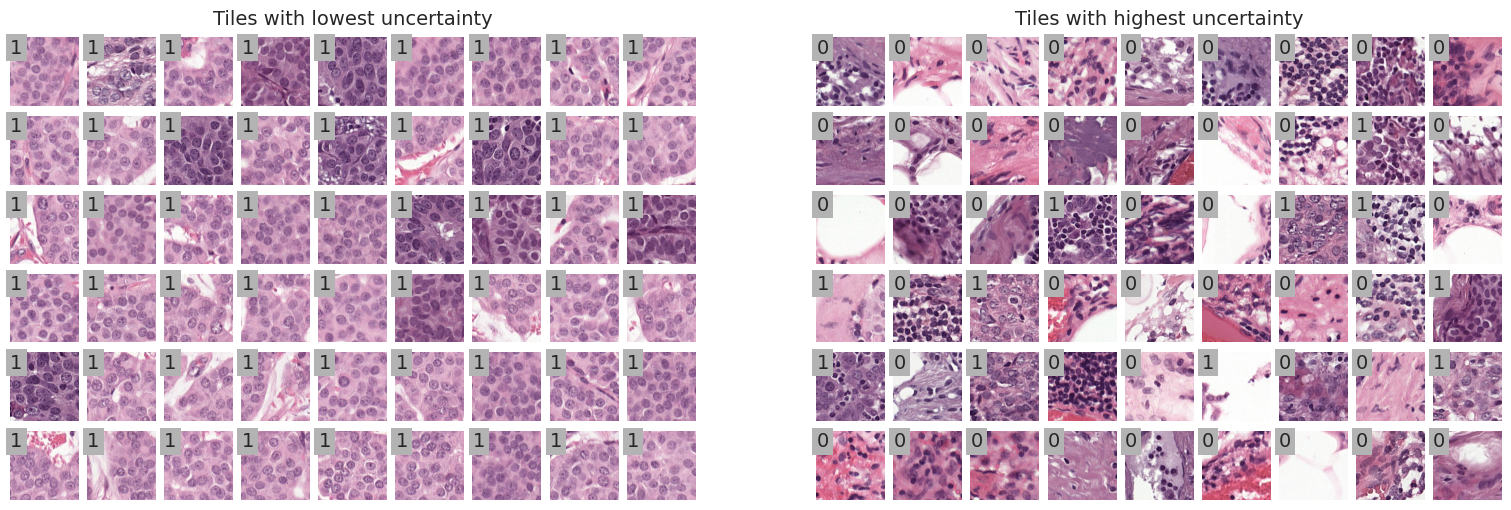

In [19]:
visualize_tiles_by_uncertainty(
    run=run, 
    split="test_id", 
    num=54, 
    nrows=6,
    ncols=9,
    # fname = SAVE_PATH / "tiles_by_uncertainty.pdf"
)

We can also visualize the tile-predicitons on slide-level (Fig. 4), generated from the first ResNet Ensemble:

Generating Camelyon17 test dataset
Generating Camelyon17 OOD dataset
Slide: patient_017_node_2


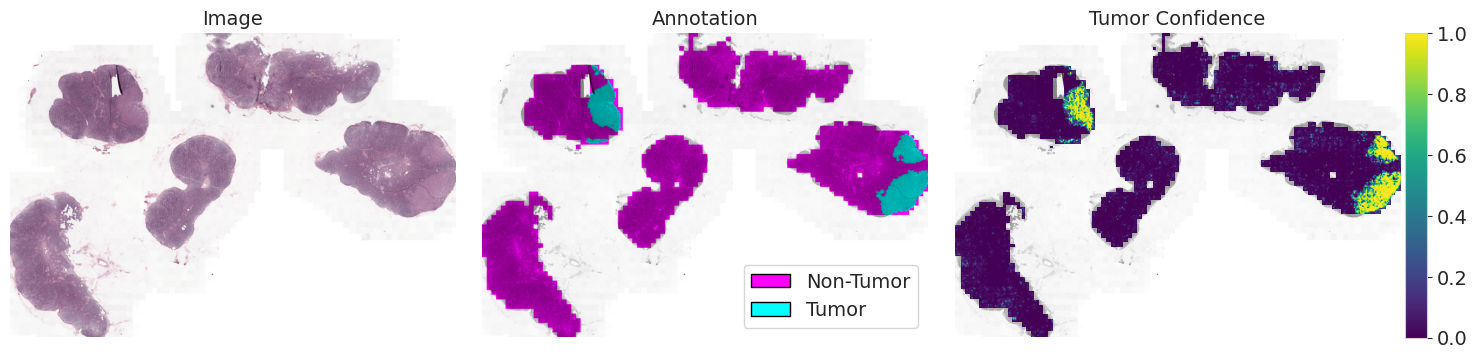

In [20]:
slides = generate_slide_vis_from_run(run, split="test_id")
plot_slide_images(
    slides, 
    idx=1, 
    # save_path=SAVE_PATH,
)

The label noise predictions take up much additional storage. This is the reason why we cannot make the predictions publicly available. In this notebook, we load the predictions from a separate storage server.

In [21]:
runs = [
    *create_runs_from_folder(Path("strong/resnet"), name="ResNet", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"25%"}, max_num=5),
    *create_ensemble_from_folder(Path("strong/resnet_ensemble"), name="ResNet Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"25%"}),
    *create_runs_from_folder(Path("strong/mcdo"), name="MCDO", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"25%"}, max_num=5),
    *create_ensemble_from_folder(Path("strong/mcdo_ensemble"), name="MCDO Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"25%"}),
    *create_runs_from_folder(Path("strong/tta"), name="TTA", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"25%"}, max_num=5),
    *create_ensemble_from_folder(Path("strong/tta_ensemble"), name="TTA Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"25%"}),
    *create_runs_from_folder(Path("strong/svi"), name="SVI", run_dir = RUN_DIR, config_path=CONFIG_PATH, max_num=5, properties={"label_noise_lvl":"25%"}),
    *create_ensemble_from_folder(Path("strong/svi"), name="SVI Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"25%"}),

    
    *create_runs_from_folder(Path("LabelNoise/0-Threshold/LNResNetNone"), name="ResNet", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/0-Threshold/LNResNetNone"), name="ResNet Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}),
    *create_runs_from_folder(Path("LabelNoise/0-Threshold/LabelNoiseMCDONone"), name="MCDO", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/0-Threshold/LabelNoiseMCDONone"), name="MCDO Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}),
    *create_runs_from_folder(Path("LabelNoise/0-Threshold/LabelNoiseTTANone"), name="TTA", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/0-Threshold/LabelNoiseTTANone"), name="TTA Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}),
    *create_runs_from_folder(Path("LabelNoise/0-Threshold/LabelNoiseSVINone"), name="SVI", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/0-Threshold/LabelNoiseSVINone"), name="SVI Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"0%"}),

    
    *create_runs_from_folder(Path("LabelNoise/Uniform/LabelNoiseResNetUniform"), name="ResNet", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Uniform/LabelNoiseResNetUniform"), name="ResNet Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}),
    *create_runs_from_folder(Path("LabelNoise/Uniform/LabelNoiseMCDOUniform"), name="MCDO", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Uniform/LabelNoiseMCDOUniform"), name="MCDO Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}),
    *create_runs_from_folder(Path("LabelNoise/Uniform/LabelNoiseTTAUniform"), name="TTA", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Uniform/LabelNoiseTTAUniform"), name="TTA Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}),
    *create_runs_from_folder(Path("LabelNoise/Uniform/LabelNoiseSVIUniform"), name="SVI", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Uniform/LabelNoiseSVIUniform"), name="SVI Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Uniform"}),

    
    *create_runs_from_folder(Path("LabelNoise/Edge/LabelNoiseResNetEdgeUniform"), name="ResNet", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Edge/LabelNoiseResNetEdgeUniform"), name="ResNet Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}),
    *create_runs_from_folder(Path("LabelNoise/Edge/LabelNoiseMCDOEdgeUniform"), name="MCDO", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Edge/LabelNoiseMCDOEdgeUniform"), name="MCDO Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}),
    *create_runs_from_folder(Path("LabelNoise/Edge/LabelNoiseTTAEdgeUniform"), name="TTA", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Edge/LabelNoiseTTAEdgeUniform"), name="TTA Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}),
    *create_runs_from_folder(Path("LabelNoise/Edge/LabelNoiseSVIEdgeUniform"), name="SVI", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}, max_num=5),
    *create_ensemble_from_folder(Path("LabelNoise/Edge/LabelNoiseSVIEdgeUniform"), name="SVI Ensemble", run_dir = RUN_DIR, config_path=CONFIG_PATH, properties={"label_noise_lvl":"Border"}),
]
print("Total number of runs: ", len(runs))

Total number of runs:  154


Computing test_id metrics.


  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:48<00:00,  3.16it/s]


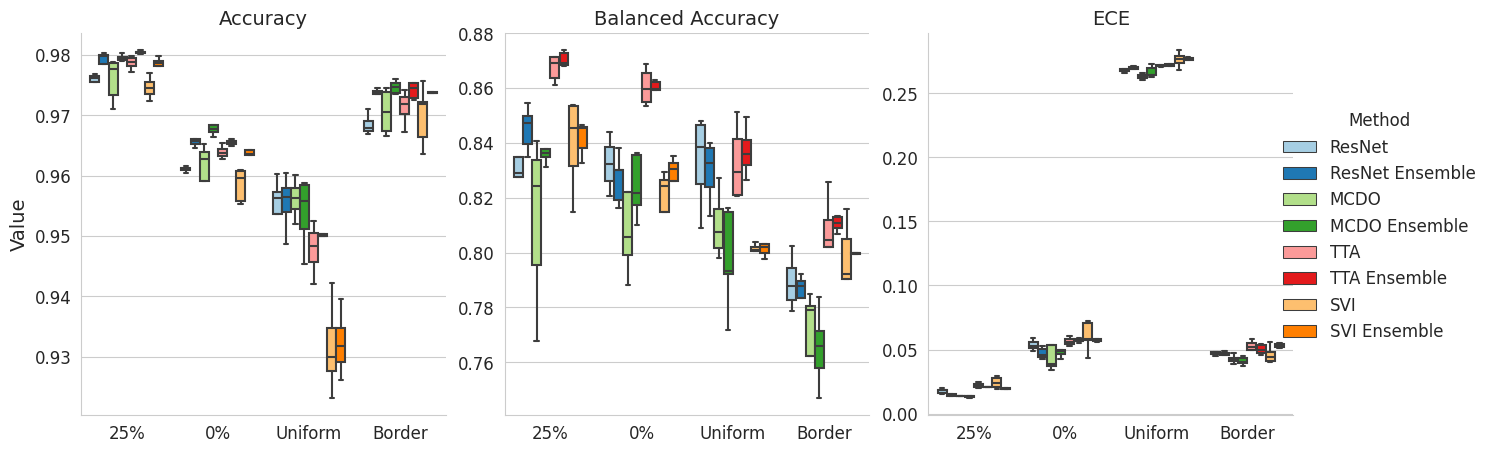

In [22]:
df_ln = compute_metrics_label_noise(
    runs, 
    split=["test_id"], 
    metrics=["Accuracy", "Balanced Accuracy", "ECE"],
    rc_args={"xtick.labelsize": 12, "ytick.labelsize": 12, "legend.fontsize": 12, "legend.title_fontsize": 12},
    color_palette="Paired",
    # fname = SAVE_PATH / "label_noise_boxplot.pdf",
)

In [23]:
# Print results as LaTeX table
print_latex_table(df_ln)

\begin{tabular}{lllll}
\toprule
        &              &             Accuracy &    Balanced Accuracy &                  ECE \\
split & method &                      &                      &                      \\
\midrule
0% & MCDO &  $ 0.963_{\pm0.005}$ &  $ 0.806_{\pm0.023}$ &  $ 0.039_{\pm0.017}$ \\
        & MCDO Ensemble &  $ 0.968_{\pm0.001}$ &  $ 0.822_{\pm0.018}$ &  $ 0.049_{\pm0.003}$ \\
        & ResNet &  $ 0.961_{\pm0.000}$ &  $ 0.832_{\pm0.012}$ &  $ 0.053_{\pm0.005}$ \\
        & ResNet Ensemble &  $ 0.966_{\pm0.001}$ &  $ 0.830_{\pm0.011}$ &  $ 0.046_{\pm0.006}$ \\
        & SVI &  $ 0.960_{\pm0.005}$ &  $ 0.824_{\pm0.011}$ &  $ 0.059_{\pm0.013}$ \\
        & SVI Ensemble &  $ 0.964_{\pm0.001}$ &  $ 0.831_{\pm0.006}$ &  $ 0.057_{\pm0.002}$ \\
        & TTA &  $ 0.964_{\pm0.001}$ &  $ 0.860_{\pm0.010}$ &  $ 0.056_{\pm0.004}$ \\
        & TTA Ensemble &  $ 0.965_{\pm0.001}$ &  $ 0.860_{\pm0.003}$ &  $ 0.057_{\pm0.001}$ \\
25% & MCDO &  $ 0.978_{\pm0.005}$ &  $ 0.824_{\pm0

In [24]:
# Reset environment
os.environ.clear()
os.environ.update(_environ)